# 4 layers model

#### Gathering of all functions needed to train a model:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.models import load_model
from numpy import argmax

def read_csv(filename):
    dataset = pd.read_csv(filename, encoding='utf-8')
    return dataset

def one_hot_encode(dataset):
    dataset_one_hot_encoded = pd.get_dummies(dataset)  
    return dataset_one_hot_encoded

def divide_X_y(dataset, index_sep):
    X = dataset.iloc[:,:index_sep]
    y = dataset.iloc[:,index_sep:]
    return X,y

def split_train_test(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    return X_train, X_test, y_train, y_test
    
def graph_loss_vs_epochs(history, save_image_filename, title):
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']
    epoch_count = range(1, len(training_loss) + 1)
    plt.title(title)
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.axvline(x = epoch_count[test_loss.index(min(test_loss))], color = 'c', linestyle="dotted")
    plt.savefig(save_image_filename)
    plt.show()
    
def save_history(filename, model):
    # ejemplo de filename:'history1.npy'
    np.save(filename,model.history.history)
    
def load_history(filename):
    history=np.load(filename,allow_pickle='TRUE').item()
    return history

def evaluate_model(model, X_test, y_test):
    print('\nEvaluating:')
    (test_loss, test_accuracy) = model.evaluate(X_test, y_test)
    print(f'\nTest accuracy: {test_accuracy * 100:>0.1f}%, test loss: {test_loss:>8f}')
    
def get_label(column):
    label = y_test.columns[column]
    return label.replace('Nivel de Adaptación_', '')

def fill_test_ds_labels(model, test_ds_filename, output_test_filename):
    test_ds = read_csv(test_ds_filename)
    test_ds = pd.get_dummies(test_ds)
    nivel_de_adaptacion_test_ds = []
    for index,test in test_ds.iterrows():
        test_ds_pred = pd.DataFrame(test).transpose()
        test_oh = pd.get_dummies(test_ds_pred)
        prediction = model.predict(test_oh)
        nivel_de_adaptacion_test_ds.append((index+1,get_label(argmax(prediction))))
    print(len(nivel_de_adaptacion_test_ds))
    nivel_de_adaptacion_df = pd.DataFrame(nivel_de_adaptacion_test_ds, columns=['id','Nivel de Adaptación']).reset_index(drop=True)
    nivel_de_adaptacion_df.to_csv(output_test_filename,index=False)

##### Loading, preparing and dividing dataset for Experiments:

In [3]:
index_sep = 31
test_size=0.2
dataset = read_csv('../training-ds.csv')
dataset = one_hot_encode(dataset)
X, y = divide_X_y(dataset, index_sep)
X_train, X_test, y_train, y_test = split_train_test(X, y, test_size)

##### Model_4 v1
    4 layers
    learning_rate = 0.001
    batch_size = 32
    optimizer: ADAM
    Dense units:  32,32,64,64

Epoch 1/4000
25/25 - 3s - loss: 1.0071 - accuracy: 0.5045 - val_loss: 0.8849 - val_accuracy: 0.5596

Epoch 00001: val_loss improved from inf to 0.88494, saving model to models\model_4L_v1
INFO:tensorflow:Assets written to: models\model_4L_v1\assets
Epoch 2/4000
25/25 - 0s - loss: 0.8673 - accuracy: 0.5759 - val_loss: 0.8072 - val_accuracy: 0.6321

Epoch 00002: val_loss improved from 0.88494 to 0.80724, saving model to models\model_4L_v1
INFO:tensorflow:Assets written to: models\model_4L_v1\assets
Epoch 3/4000
25/25 - 0s - loss: 0.7954 - accuracy: 0.6394 - val_loss: 0.7278 - val_accuracy: 0.6684

Epoch 00003: val_loss improved from 0.80724 to 0.72780, saving model to models\model_4L_v1
INFO:tensorflow:Assets written to: models\model_4L_v1\assets
Epoch 4/4000
25/25 - 0s - loss: 0.7260 - accuracy: 0.6667 - val_loss: 0.6668 - val_accuracy: 0.7098

Epoch 00004: val_loss improved from 0.72780 to 0.66681, saving model to models\model_4L_v1
INFO:tensorflow:Assets written to: models\model_4L_v1

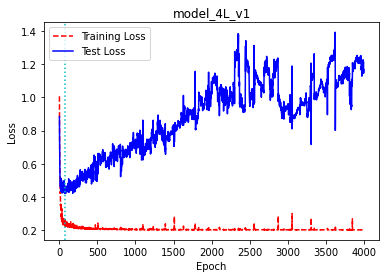

In [21]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
       tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3)
    ])
learning_rate = 0.001
batch_size = 32
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_4L_v1'
model_l_v_e_filename = 'loss_vs_epochs_images/model_4L_v1_le.png'
model_l_v_e_title = 'model_4L_v1'
model_history_filename = 'history/history_model_4L_v1'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 4000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [22]:
best_m4L_v1 = load_model(model_filename)
evaluate_model(best_m4L_v1, X_test, y_test)


Evaluating:
7/7 [==============================] - 1s 5ms/step - loss: 0.4197 - accuracy: 0.8187

Test accuracy: 81.9%, test loss: 0.419727


In [23]:
test_ds_filename = '../test-ds.csv'
output_filename_test_ds_labeled = 'test-ds-m4L_v1.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241


##### Model_4 v2
    4 layers
    learning_rate = 0.01
    batch_size = 32
    optimizer: ADAM
    Dense units:  32,32,64,64

Epoch 1/4000
25/25 - 3s - loss: 0.8374 - accuracy: 0.5875 - val_loss: 0.7601 - val_accuracy: 0.6839

Epoch 00001: val_loss improved from inf to 0.76014, saving model to models\model_4L_v2
INFO:tensorflow:Assets written to: models\model_4L_v2\assets
Epoch 2/4000
25/25 - 0s - loss: 0.6892 - accuracy: 0.6848 - val_loss: 0.6124 - val_accuracy: 0.7565

Epoch 00002: val_loss improved from 0.76014 to 0.61238, saving model to models\model_4L_v2
INFO:tensorflow:Assets written to: models\model_4L_v2\assets
Epoch 3/4000
25/25 - 0s - loss: 0.6433 - accuracy: 0.7121 - val_loss: 0.6857 - val_accuracy: 0.6736

Epoch 00003: val_loss did not improve from 0.61238
Epoch 4/4000
25/25 - 0s - loss: 0.5784 - accuracy: 0.7341 - val_loss: 0.6130 - val_accuracy: 0.7409

Epoch 00004: val_loss did not improve from 0.61238
Epoch 5/4000
25/25 - 0s - loss: 0.5329 - accuracy: 0.7601 - val_loss: 0.5286 - val_accuracy: 0.7720

Epoch 00005: val_loss improved from 0.61238 to 0.52862, saving model to models\model_4L_v2
IN

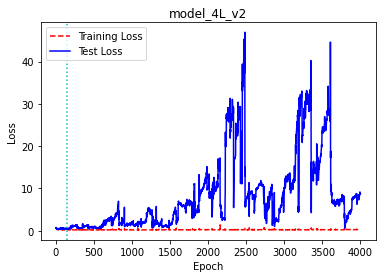

In [4]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
       tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3)
    ])
learning_rate = 0.01
batch_size = 32
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_4L_v2'
model_l_v_e_filename = 'loss_vs_epochs_images/model_4L_v2_le.png'
model_l_v_e_title = 'model_4L_v2'
model_history_filename = 'history/history_model_4L_v2'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 4000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [5]:
best_m4L_v2 = load_model(model_filename)
evaluate_model(best_m4L_v2, X_test, y_test)


Evaluating:
7/7 [==============================] - 0s 3ms/step - loss: 0.3286 - accuracy: 0.8394

Test accuracy: 83.9%, test loss: 0.328615


In [6]:
test_ds_filename = '../test-ds.csv'
output_filename_test_ds_labeled = 'test-ds-m4L_v2jvvuidh.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241


##### Model_4 v3
    4 layers
    learning_rate = 0.005
    batch_size = 32
    optimizer: ADAM
    Dense units: 64,64,96,96

Epoch 1/4000
25/25 - 2s - loss: 0.8379 - accuracy: 0.5888 - val_loss: 0.7012 - val_accuracy: 0.6943

Epoch 00001: val_loss improved from inf to 0.70120, saving model to models\model_4L_v2
INFO:tensorflow:Assets written to: models\model_4L_v2\assets
Epoch 2/4000
25/25 - 0s - loss: 0.6899 - accuracy: 0.6809 - val_loss: 0.7038 - val_accuracy: 0.6943

Epoch 00002: val_loss did not improve from 0.70120
Epoch 3/4000
25/25 - 1s - loss: 0.6062 - accuracy: 0.7341 - val_loss: 0.6074 - val_accuracy: 0.7306

Epoch 00003: val_loss improved from 0.70120 to 0.60737, saving model to models\model_4L_v2
INFO:tensorflow:Assets written to: models\model_4L_v2\assets
Epoch 4/4000
25/25 - 1s - loss: 0.5125 - accuracy: 0.7756 - val_loss: 0.4999 - val_accuracy: 0.7876

Epoch 00004: val_loss improved from 0.60737 to 0.49988, saving model to models\model_4L_v2
INFO:tensorflow:Assets written to: models\model_4L_v2\assets
Epoch 5/4000
25/25 - 0s - loss: 0.4209 - accuracy: 0.8223 - val_loss: 0.4739 - val_accuracy: 

FileNotFoundError: [Errno 2] No such file or directory: 'loss_vs_epochs_images/model_4L_v2_le.png'

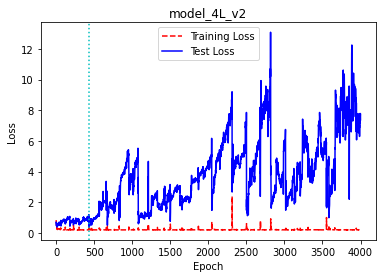

In [6]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
       tf.keras.layers.Dense(96, activation='relu'),
      tf.keras.layers.Dense(96, activation='relu'),
      tf.keras.layers.Dense(3)
    ])
learning_rate = 0.005
batch_size = 32
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_4L_v2'
model_l_v_e_filename = 'loss_vs_epochs_images/model_4L_v2_le.png'
model_l_v_e_title = 'model_4L_v2'
model_history_filename = 'history/history_model_4L_v2'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 4000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [7]:
best_m4L_v2 = load_model(model_filename)
evaluate_model(best_m4L_v2, X_test, y_test)


Evaluating:
7/7 [==============================] - 0s 3ms/step - loss: 0.3978 - accuracy: 0.8135

Test accuracy: 81.3%, test loss: 0.397790


In [ ]:
test_ds_filename = '../test-ds.csv'
output_filename_test_ds_labeled = 'test-ds-m4L_v3.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

##### Model_4 v4
    4 layers
    learning_rate = 0.005
    batch_size = 64
    optimizer: ADAM
    Dense units:  32,32,64,64
    Activation=sigmoid

Epoch 1/4000
13/13 - 2s - loss: 0.8813 - accuracy: 0.5720 - val_loss: 0.8350 - val_accuracy: 0.6736

Epoch 00001: val_loss improved from inf to 0.83496, saving model to models\model_4L_v3
INFO:tensorflow:Assets written to: models\model_4L_v3\assets
Epoch 2/4000
13/13 - 0s - loss: 0.7920 - accuracy: 0.6433 - val_loss: 0.7327 - val_accuracy: 0.6891

Epoch 00002: val_loss improved from 0.83496 to 0.73265, saving model to models\model_4L_v3
INFO:tensorflow:Assets written to: models\model_4L_v3\assets
Epoch 3/4000
13/13 - 0s - loss: 0.7153 - accuracy: 0.6744 - val_loss: 0.6520 - val_accuracy: 0.7254

Epoch 00003: val_loss improved from 0.73265 to 0.65198, saving model to models\model_4L_v3
INFO:tensorflow:Assets written to: models\model_4L_v3\assets
Epoch 4/4000
13/13 - 0s - loss: 0.6476 - accuracy: 0.7017 - val_loss: 0.6284 - val_accuracy: 0.7098

Epoch 00004: val_loss improved from 0.65198 to 0.62839, saving model to models\model_4L_v3
INFO:tensorflow:Assets written to: models\model_4L_v3

FileNotFoundError: [Errno 2] No such file or directory: 'loss_vs_epochs_images/model_4L_v3_le.png'

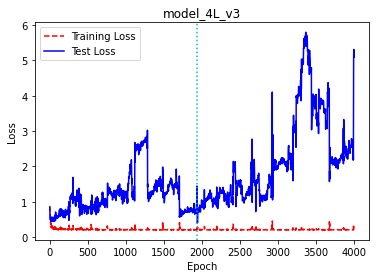

In [3]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(32, activation='sigmoid'),
      tf.keras.layers.Dense(32, activation='sigmoid'),
       tf.keras.layers.Dense(64, activation='sigmoid'),
      tf.keras.layers.Dense(64, activation='sigmoid'),
      tf.keras.layers.Dense(3)
    ])
learning_rate = 0.005
batch_size = 64
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_4L_v4'
model_l_v_e_filename = 'loss_vs_epochs_images/model_4L_v4_le.png'
model_l_v_e_title = 'model_4L_v4'
model_history_filename = 'history/history_model_4L_v4'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 4000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [4]:
best_m4L_v3 = load_model(model_filename)
evaluate_model(best_m4L_v3, X_test, y_test)


Evaluating:
7/7 [==============================] - 0s 3ms/step - loss: 0.3958 - accuracy: 0.8446

Test accuracy: 84.5%, test loss: 0.395759


In [5]:
test_ds_filename = '../test-ds.csv'
output_filename_test_ds_labeled = 'test-ds-m4L_v3.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241


##### Model_4 v5
    4 layers
    learning_rate = 0.01
    batch_size = 32
    optimizer: ADAM
    Dense units: 16,16,32,32

Epoch 1/4000
25/25 - 3s - loss: 0.8974 - accuracy: 0.5655 - val_loss: 0.7272 - val_accuracy: 0.6580

Epoch 00001: val_loss improved from inf to 0.72718, saving model to models\model_4L_v4
INFO:tensorflow:Assets written to: models\model_4L_v4\assets
Epoch 2/4000
25/25 - 0s - loss: 0.7694 - accuracy: 0.6680 - val_loss: 0.7258 - val_accuracy: 0.7098

Epoch 00002: val_loss improved from 0.72718 to 0.72582, saving model to models\model_4L_v4
INFO:tensorflow:Assets written to: models\model_4L_v4\assets
Epoch 3/4000
25/25 - 0s - loss: 0.6907 - accuracy: 0.7160 - val_loss: 0.6268 - val_accuracy: 0.7306

Epoch 00003: val_loss improved from 0.72582 to 0.62681, saving model to models\model_4L_v4
INFO:tensorflow:Assets written to: models\model_4L_v4\assets
Epoch 4/4000
25/25 - 0s - loss: 0.6404 - accuracy: 0.7289 - val_loss: 0.6402 - val_accuracy: 0.7513

Epoch 00004: val_loss did not improve from 0.62681
Epoch 5/4000
25/25 - 0s - loss: 0.6065 - accuracy: 0.7237 - val_loss: 0.5591 - val_accuracy: 

FileNotFoundError: [Errno 2] No such file or directory: 'loss_vs_epochs_images/model_4L_v4_le.png'

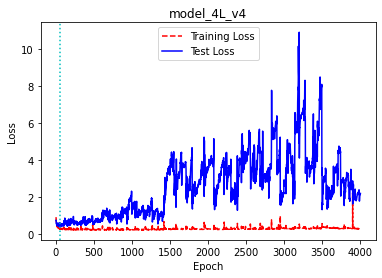

In [4]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
       tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(3)
    ])
learning_rate = 0.01
batch_size = 32
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_4L_v4'
model_l_v_e_filename = 'loss_vs_epochs_images/model_4L_v4_le.png'
model_l_v_e_title = 'model_4L_v4'
model_history_filename = 'history/history_model_4L_v4'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 4000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [5]:
best_m4L_v4 = load_model(model_filename)
evaluate_model(best_m4L_v4, X_test, y_test)


Evaluating:
7/7 [==============================] - 0s 2ms/step - loss: 0.3775 - accuracy: 0.8342

Test accuracy: 83.4%, test loss: 0.377546


In [7]:
test_ds_filename = '../test-ds.csv'
output_filename_test_ds_labeled = 'test-ds-m4L_v4.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241


##### Model_4 v6
    4 layers
    learning_rate = 0.001
    batch_size = 64
    optimizer: ADAM
    Dense units: 32,64,96,128

Epoch 1/4000
13/13 - 2s - loss: 0.9619 - accuracy: 0.5123 - val_loss: 0.8924 - val_accuracy: 0.5855

Epoch 00001: val_loss improved from inf to 0.89235, saving model to models\model_4L_v5
INFO:tensorflow:Assets written to: models\model_4L_v5\assets
Epoch 2/4000
13/13 - 0s - loss: 0.8617 - accuracy: 0.6252 - val_loss: 0.8376 - val_accuracy: 0.6114

Epoch 00002: val_loss improved from 0.89235 to 0.83756, saving model to models\model_4L_v5
INFO:tensorflow:Assets written to: models\model_4L_v5\assets
Epoch 3/4000
13/13 - 0s - loss: 0.8050 - accuracy: 0.6239 - val_loss: 0.8011 - val_accuracy: 0.6477

Epoch 00003: val_loss improved from 0.83756 to 0.80109, saving model to models\model_4L_v5
INFO:tensorflow:Assets written to: models\model_4L_v5\assets
Epoch 4/4000
13/13 - 0s - loss: 0.7633 - accuracy: 0.6355 - val_loss: 0.7519 - val_accuracy: 0.6891

Epoch 00004: val_loss improved from 0.80109 to 0.75195, saving model to models\model_4L_v5
INFO:tensorflow:Assets written to: models\model_4L_v5

FileNotFoundError: [Errno 2] No such file or directory: 'loss_vs_epochs_images/model_4L_v5_le.png'

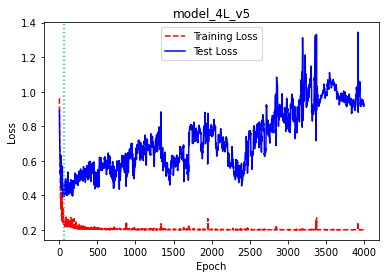

In [9]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
       tf.keras.layers.Dense(96, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(3)
    ])
learning_rate = 0.001
batch_size = 64
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_4L_v5'
model_l_v_e_filename = 'loss_vs_epochs_images/model_4L_v5_le.png'
model_l_v_e_title = 'model_4L_v5'
model_history_filename = 'history/history_model_4L_v5'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 4000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [10]:
best_m4L_v5 = load_model(model_filename)
evaluate_model(best_m4L_v5, X_test, y_test)


Evaluating:
7/7 [==============================] - 0s 2ms/step - loss: 0.3931 - accuracy: 0.8187

Test accuracy: 81.9%, test loss: 0.393078


In [11]:
test_ds_filename = '../test-ds.csv'
output_filename_test_ds_labeled = 'test-ds-m4L_v5.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241
